In [13]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import MeCab
import emoji as Emoji

In [14]:
from sequence import Sequence
from load_emojis import load_emojis

In [15]:
mecab = MeCab.Tagger("-Owakati")
wakati = mecab.parse("坂本ですが").split()
print(wakati)

['坂本', 'です', 'が']


In [22]:
def read_data():
  """Get data from MongoDB as a list of words"""
  #   with zipfile.ZipFile(filename) as f:
  #     data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  #   return data
  words = list()
  for sequence in Sequence.objects:
    words.extend(mecab.parse(sequence.content).split())
    words.extend(['<EOS>'])
  return words
    
words = read_data()
print('Data size %d' % len(words))
print(words[:20])

Data size 3089186
['筋トレ', 'ガンバ', '💪', '<EOS>', '載せる', '😻', '<EOS>', 'さき', 'なお', 'めでとう', '💓', '<EOS>', '毎日', 'パイン', 'ジュース', '飲ん', 'でる', 'さき', 'なち', 'ゃんたまには']


In [24]:
vocabulary_size = 30000
emojis = load_emojis()

def build_dataset(words):
  count = [['UNK', -1]]
#   count.extend([[emoji, -1] for emoji in emojis])
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
#   for emoji in emojis:
#    dictionary[emoji] = len(dictionary)
  for word, _ in count:
#     if word not in emojis:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print(len(dictionary))
# for emoji in emojis[:10]:
#   print((emoji, dictionary[emoji]), end=", ")

# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 70993], ('<EOS>', 338474), ('て', 70672), ('た', 57721), ('の', 49844)]
Sample data [6700, 7310, 187, 1, 4898, 120, 1, 1131, 1476, 10895]
30000


In [25]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['筋トレ', 'ガンバ', '💪', '<EOS>', '載せる', '😻', '<EOS>', 'さき']

with num_skips = 2 and skip_window = 1:
    batch: ['ガンバ', 'ガンバ', '💪', '💪', '<EOS>', '<EOS>', '載せる', '載せる']
    labels: ['筋トレ', '💪', 'ガンバ', '<EOS>', '💪', '載せる', '<EOS>', '😻']

with num_skips = 4 and skip_window = 2:
    batch: ['💪', '💪', '💪', '💪', '<EOS>', '<EOS>', '<EOS>', '<EOS>']
    labels: ['載せる', '筋トレ', '<EOS>', 'ガンバ', '😻', 'ガンバ', '載せる', '💪']


In [26]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [27]:
num_steps = 100001
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0

  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k): 
          if nearest[k] < len(reverse_dictionary):
            close_word = reverse_dictionary[nearest[k]]
          else:
           close_word = nearest[k]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.877711
Nearest to とか: ボッチ, ありがたい, 印, めよ, おかげさま, た事, ダイ, 食っ,
Nearest to もう: お豆腐, 一枚目, してちょんまげ, 決めて, 揚げ, 紐, 誠に, おまえら,
Nearest to 今日: トローチ, 三月, とびっこ, チャーム, ふるか, ふみふみ, 浜, NZ,
Nearest to 嬉しい: 貰お, 06250626, にゅー, すご, クラスタ, ぁぁぁん, 筋肉痛, ぽり,
Nearest to 私: shunsuke, 捨てる, カップリング, かなた, しよう, うううっ, 酒場, ⇆,
Nearest to 🙄: 泰, みよっ, ショッピングモール, 228, じめじめ, わた, つなげ, たぜい,
Nearest to が: 世界は恋に落ちている, SU, エール, テヒョナ, ぴんぽん, 番目, 松村, 隈,
Nearest to お: しょぼい, いろはす, BeautyPlus, ひゃー, 架, れんか, 濃いめ, 27日,
Nearest to くん: サマステ, ウヒョン, (*´･, ㅋ, ラストキス, 家で, 酔っ払っ, みんな大好き,
Nearest to 😇: ハッピー, ミント, 脳, メロン, 野球, 48, ワザと, おまえに,
Nearest to …: いゆ, 視野, 私的, 渋谷すばる, 先輩, イル, ビア, ち～,
Nearest to 💦: 伸, 白鳥, うちに, しんど, s, おめでとう, 450, (´∀'),
Nearest to ね: 4日間, じんじん, 左側, ')✌(✌', フィッシャーズ, ⍢⃝, ぷよクエ, 見返す,
Nearest to (: ❕, ARASHI, 監督, 高尾, ぱぼ, バミューダ, ぜー, 応募,
Nearest to たい: 元カレ, 一緒に, よって, 癒兎, ダイエット, ぉろばさせて, 明け, 測っ,
Nearest to い: ょんくん, メチャメチャ, 誠に, umie, 被っ, まっしゅ, ﾀﾒ, kan,
Average loss at step 2000: 4.042386
Average loss at 

In [28]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

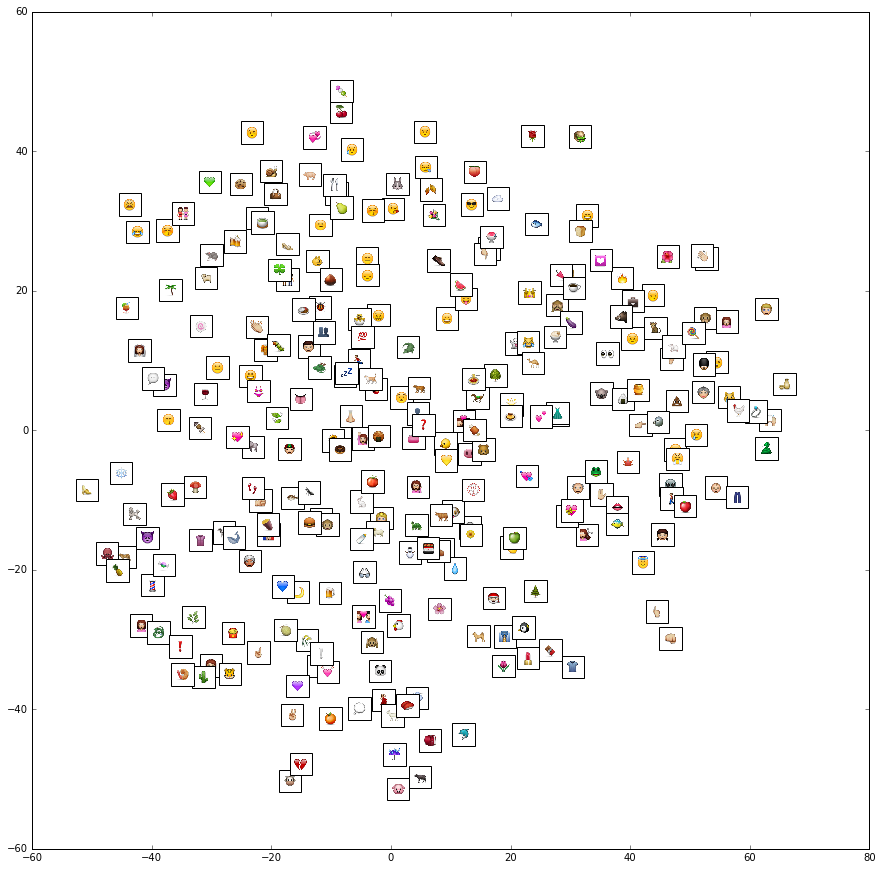

In [151]:
import matplotlib.image as mpimg
from matplotlib._png import read_png

def plot(embeddings, labels):
  #   assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  ax = plt.subplot()
  
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
 
    img_path = "./emojis/{}.png".format(shorter_demojize(label)[1:-1])
    if os.path.exists(img_path):
      pylab.scatter(x, y)

      fn = open(img_path, 'r')
      arr_emoji = read_png(fn)
    
      imagebox = OffsetImage(arr_emoji, zoom=0.2)
      ab = AnnotationBbox(imagebox, xy=(x, y))

      ax.add_artist(ab)

  pylab.show()

# words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, emojis)

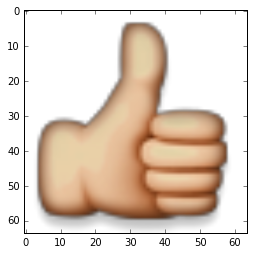

In [74]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# image_url = "https://raw.githubusercontent.com/github/gemoji/master/images/emoji/unicode/0032-20e3.png"
image_path = "/Users/vanhuy/work/lib/emoji-cheat-sheet.com/public/graphics/emojis/+1.png"
image = mpimg.imread(image_path)
plt.imshow(image)
plt.show()

In [96]:
Emoji.demojize('😇')[1:-1]

'smiling_face_with_halo'

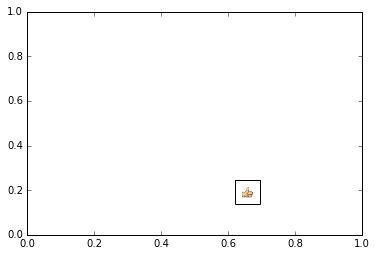

In [93]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, \
    AnnotationBbox
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png


import numpy as np

if 1:
    fig, ax = plt.subplots()
    

    img_path = "/Users/vanhuy/work/lib/emoji-cheat-sheet.com/public/graphics/emojis/+1.png"
    fn = get_sample_data(img_path, asfileobj=False)
    arr_lena = read_png(fn)

    imagebox = OffsetImage(arr_lena, zoom=0.2)

    ab = AnnotationBbox(imagebox, xy,
                        xybox=(120., -80.),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.5
                        )

    ax.add_artist(ab)

   

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.draw()
    plt.show()

In [143]:
p = "/Users/vanhuy/work/lib/emoji-cheat-sheet.com/public/graphics/emojis/{}.png".format(shorter_demojize('😇')[1:-1])

In [144]:
os.path.exists(p)

True

In [133]:
Emoji.demojize(emojis[2])

':face_with_tears_of_joy:'

In [125]:
emojis[2]

'😂'

In [147]:
len(emojis)

400

In [141]:
def shorter_demojize(emoji):
  emojis_table = Emoji.unicode_codes.EMOJI_ALIAS_UNICODE
  reverse_emojis_table = dict(zip(emojis_table.values(), emojis_table.keys()))
  return reverse_emojis_table.get(emoji)

shorter_demojize('😂')

':joy:'